In [3]:
import cv2
import numpy as np
import threading
from matplotlib import pyplot as plt

faces found:  0


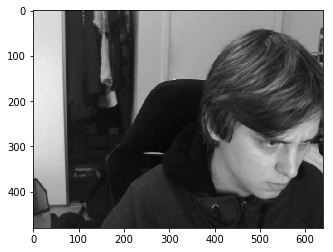

In [4]:
haar_cascade = cv2.CascadeClassifier(
    'data/haarcascade_frontalface_alt.xml')
cam = cv2.VideoCapture(0)
ret_val, img = cam.read()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
print("faces found: ", len(faces))
for (x, y, w, h) in faces:     
         cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 255, 0), 2)
plt.imshow(gray,cmap="gray")

In [5]:

class data():
    def __init__(self):
        self.faces = None
        self.latestim = None
        self.gotimage = False
        self.gotface = False
        self.done = False



def get_faces(data):
    print("detecting faces")
    while not data.done:
        if data.gotimage:
            newfaces = haar_cascade.detectMultiScale(data.latestim, scaleFactor=1.1, minNeighbors=5)
            data.faces = newfaces
            data.gotface = True
    print("face detection stopped")
            

def display(data):
    cam = cv2.VideoCapture(0)
    while True:
        ret_val, img = cam.read()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #gray = cv2.flip(gray, 1)
        data.latestim = gray
        data.gotimage = True
        if data.gotface:
            for (x, y, w, h) in data.faces: 
                cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                img = img[y:y+h,x:x+w]    
        
        cv2.imshow('my webcam', img)

        if cv2.waitKey(1) == 27: 
            data.done= True
            break  # esc to quit
    cv2.destroyAllWindows()


In [6]:
shared = data()
threading.Thread(target=display,args=[shared]).start()
threading.Thread(target=get_faces, args=[shared]).start()

detecting faces
face detection stopped


In [1]:
import tensorflow as tf
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "checkpoints/model.ckpt")

ValueError: No variables to save